<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/01_cats_and_dogs_SIN_DATA_AUGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1CpfC-e5doyIQUXoaOUMDLeTL7EKR9UMu

- Poner variable COLAB a False

In [2]:
# Basado en parte de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [4]:
!ls

sample_data


In [5]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1CpfC-e5doyIQUXoaOUMDLeTL7EKR9UMu',
                                        dest_path='./small_data.zip', unzip=True)

Unzipping...Done.


In [6]:
!ls

__MACOSX  sample_data  small_data  small_data.zip


In [7]:
!ls small_data

test0  train  validation


In [8]:
!ls small_data/train

cats  dogs


In [9]:
!ls small_data/train/cats

cat.0.jpg    cat.250.jpg  cat.400.jpg  cat.551.jpg  cat.701.jpg  cat.852.jpg
cat.100.jpg  cat.251.jpg  cat.401.jpg  cat.552.jpg  cat.702.jpg  cat.853.jpg
cat.101.jpg  cat.252.jpg  cat.402.jpg  cat.553.jpg  cat.703.jpg  cat.854.jpg
cat.102.jpg  cat.253.jpg  cat.403.jpg  cat.554.jpg  cat.704.jpg  cat.855.jpg
cat.103.jpg  cat.254.jpg  cat.404.jpg  cat.555.jpg  cat.705.jpg  cat.856.jpg
cat.104.jpg  cat.255.jpg  cat.405.jpg  cat.556.jpg  cat.706.jpg  cat.857.jpg
cat.105.jpg  cat.256.jpg  cat.406.jpg  cat.557.jpg  cat.707.jpg  cat.858.jpg
cat.106.jpg  cat.257.jpg  cat.407.jpg  cat.558.jpg  cat.708.jpg  cat.859.jpg
cat.107.jpg  cat.258.jpg  cat.408.jpg  cat.559.jpg  cat.709.jpg  cat.85.jpg
cat.108.jpg  cat.259.jpg  cat.409.jpg  cat.55.jpg   cat.70.jpg	 cat.860.jpg
cat.109.jpg  cat.25.jpg   cat.40.jpg   cat.560.jpg  cat.710.jpg  cat.861.jpg
cat.10.jpg   cat.260.jpg  cat.410.jpg  cat.561.jpg  cat.711.jpg  cat.862.jpg
cat.110.jpg  cat.261.jpg  cat.411.jpg  cat.562.jpg  cat.712.jpg  cat.863.jpg
c

In [10]:
ficheros = glob("./small_data/train/cats/*jpg")
ficheros[0]

'./small_data/train/cats/cat.337.jpg'

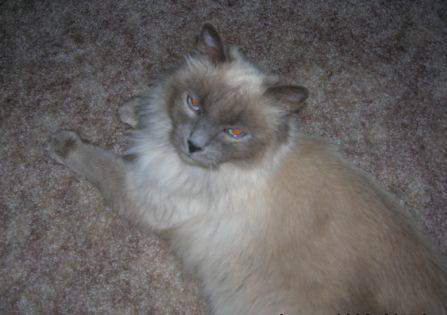

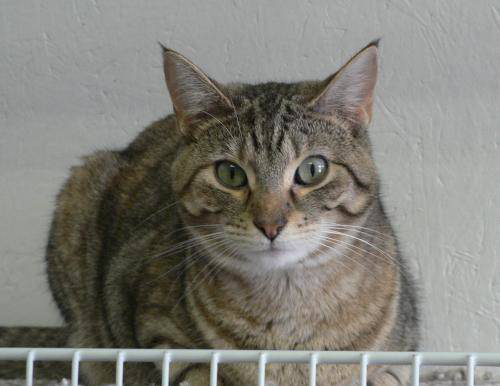

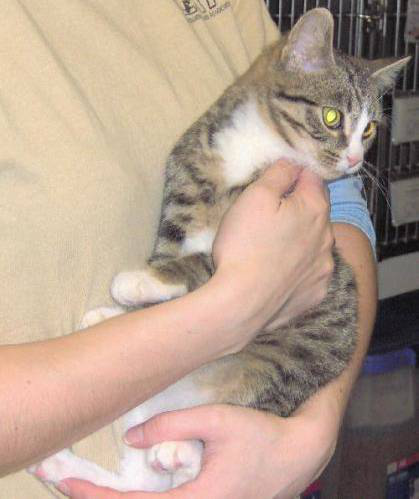

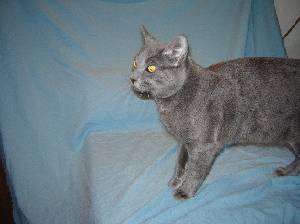

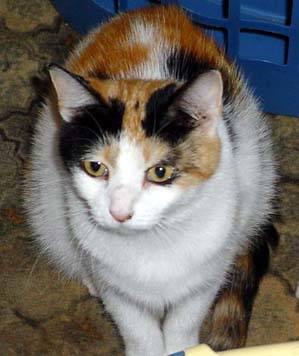

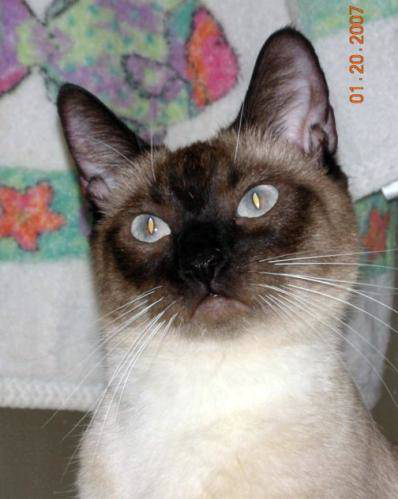

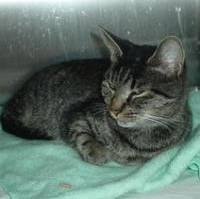

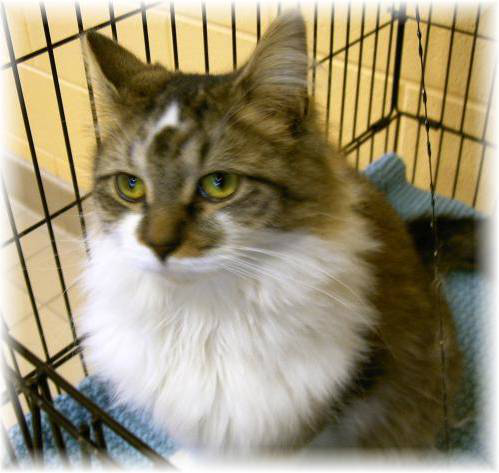

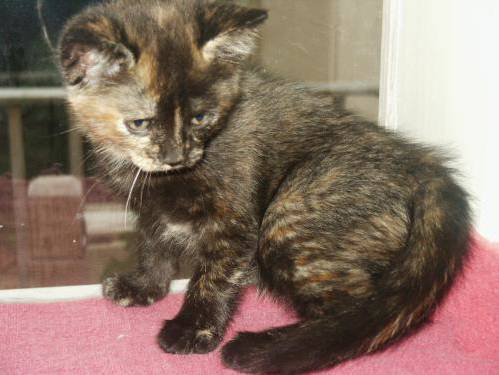

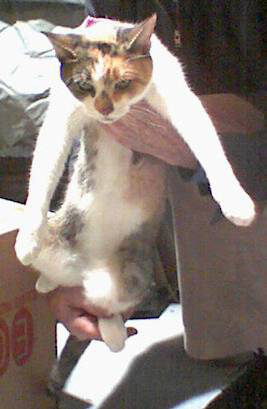

In [11]:
for fich in ficheros[:10]:
    imagen = load_img(fich)
    display(imagen)
    print()

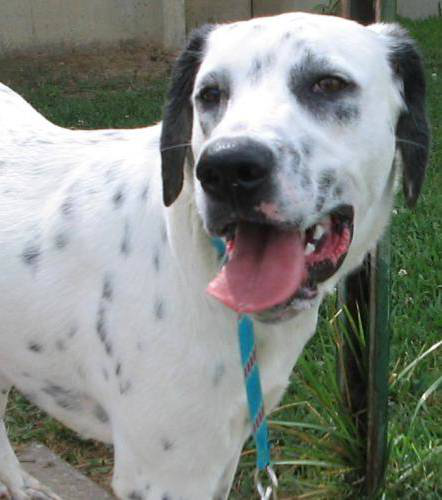

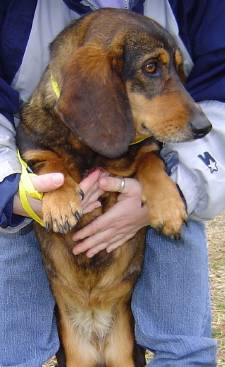

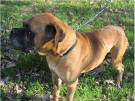

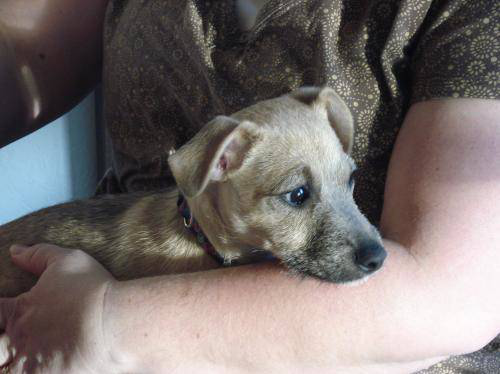

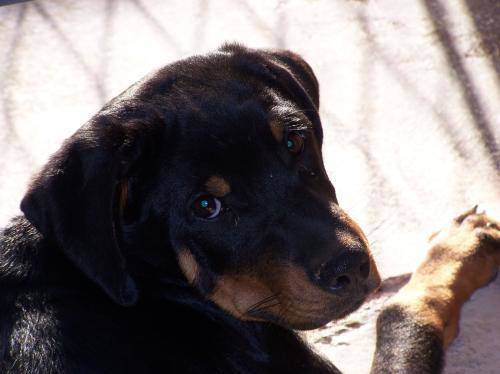

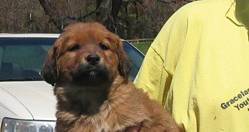

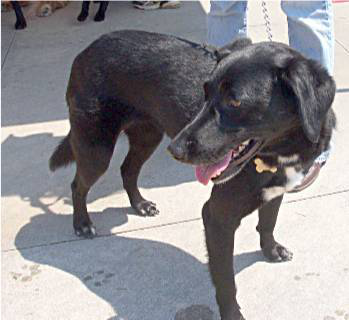

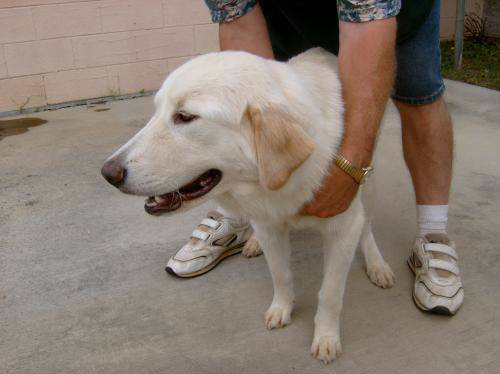

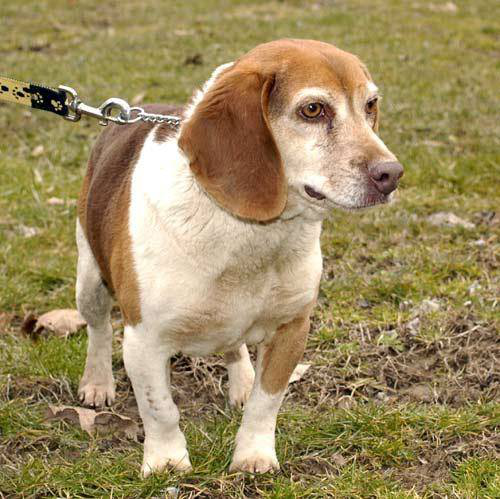

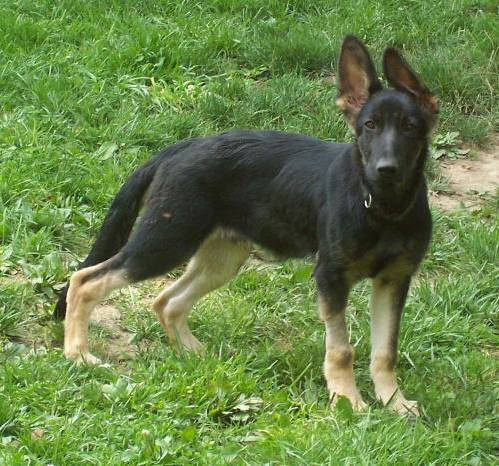

In [12]:
ficheros = glob("./small_data/train/dogs/*jpg")
for fich in ficheros[:10]:
    imagen = load_img(fich)
    display(imagen)
    print()

In [13]:
train_data_dir = 'small_data/train'
validation_data_dir = 'small_data/validation'
test_data_dir = 'small_data/test0'

batch_size = 16

A continuación vamos a definir un ImageDataGenerator que es lo que nos servirá para realizar data augmentation.

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [ ]:
preprocess_input = lambda x:x/255.

In [ ]:
# data augmentation:

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
#    rotation_range=20,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    fill_mode='nearest',
#    shear_range=0.1,
#    zoom_range=0.2,
#    horizontal_flip=True
    )

In [ ]:
imagen_num = np.expand_dims(np.array(imagen), axis=0)

In [ ]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## **Red convolucional**

In [ ]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [ ]:
normed_dims

###**Loss del modelo por defecto en clasificación**

El loss típico en redes neuronales y regresión logística (función de coste que minimiza el algoritmo de optimización) es el llamado **cross-entropy** (entropía cruzada) o **log-loss**:

**log-loss = promedio( ln ( 1 / Pmodelo(clase real) ))**

donde ln es el logaritmo neperiano y Pmodelo(clase real) es la probabilidad, según el modelo, de la clase real para un ejemplo concreto.

El log-loss nunca puede ser negativo ya que (1 / Pmodelo) es mayor o igual que 1 y por tanto el logaritmo nunca es menor que cero.

Por otra parte la única manera de que el log-loss sea cero es que Pmodelo(clase real) sea siempre 1, lo que equivale a decir que el modelo siempre acierta con la clase "sin dudarlo" (la probabilidad asignada es siempre 1).

Algunos ejemplos con diferentes probabilidades:

- Si Pmodelo(clase real) = 1 entonces ln( 1 / Pmodelo(clase real) ) = ln(1 / 1) = 0

- Si Pmodelo(clase real) = 0.8 (el modelo "acierta" pero no está completamente seguro) entonces ln( 1 / Pmodelo (clase real) ) = ln(1 / 0.8) > 0

- Si Pmodelo(clase real) = 0 (el modelo se equivoca completamente), ln( 1 / Pmodelo (clase real) ) = ln(1 / 0) = infinito

Una variante del log-loss es introducir pesos en las clases. En keras esto se introduce en el parámetro class_weight en el método **fit** para entrenar el modelo. La variante es entonces:

**log-loss = promedio( peso clase real · ln ( 1 / Pmodelo(clase real) ))**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
#    rotation_range=40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    fill_mode='nearest',
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True
)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [ ]:
validation_data_dir, normed_dims

**flow_from_directory (a continuación):**

- Los datos están en la carpeta que indiquemos. De ella cuelgan tantas subcarpetas como clases. Si hay N subcarpetas habrá por tanto N clases. El índice asignado a cada clase es su posición en orden alfabético empezando por 0. **Ejemplo:** si las subcarpetas son 'birds', 'cats' y 'dogs', los índices son respectivamente 0, 1, 2

- **shuffle=True**: los datos se recorren en orden aleatorio.

- **class_mode='categorical'**: las clases se codifican con one-hot. En el caso de tres carpetas 'birds', 'cats' y 'dogs', a todos los ficheros en la carpeta 'birds' se les asigna la clase 1, 0, 0. A todos los ficheros de 'cats' se les asigna 0, 1, 0, y a todos los de 'dogs' 0, 0, 1. **Importante**: en la capa de salida debe haber activación **softmax** y el loss en el compile debe ser **categorical_crossentropy**.

- **class_mode='binary'**: hay dos clases (0 y 1). En el caso de dos carpetas 'cats' y 'dogs', a todos los ficheros en la carpeta 'cats' se les asigna 0 y a todos los de 'dogs' 1. **Importante**: en la capa de salida debe haber activación **binary** y el loss en el compile debe ser **binary_crossentropy**.

- **class_mode='sparse'**: las clases se codifican directamente con su índice. En el caso de tres carpetas 'birds', 'cats' y 'dogs', a todos los ficheros en la carpeta 'birds' se les asigna la clase 0, a todos los ficheros de 'cats' se les asigna 1, y a todos los de 'dogs' 2. **Importante**: en la capa de salida debe haber activación **softmax** y el loss en el compile debe ser **sparse_categorical_crossentropy**.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical') # binary, categorical, sparse

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical') # binary, categorical, sparse

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical') # binary, categorical, sparse

In [ ]:
train_generator.class_indices

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
epochs = 50

modelpath="model_current_best_parte3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

In [ ]:
y_real = test_generator.classes
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágnes del directorio test
    shuffle=False,
    class_mode='categorical')

In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
class_indices = test_generator2.class_indices
class_indices

In [ ]:
X_te.shape

In [ ]:
X_te.max()

In [ ]:
ind_te1 = 1500

image = X_te[ind_te1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## **Visualización del funcionamiento de la red**

In [ ]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

In [ ]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 7 # número de columnas en la figura


ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()
for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)
for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

### **Visualización de las salidas de una sola capa**

In [ ]:
# salida de una sola capa
ncapa = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()
print("\n\n")
if COLAB:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
imagen = X_te[1005]
imagen.shape

In [ ]:
ejemplo = 10

imagen = X_te[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

### **Visualización de las salidas de varias capas**

In [ ]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_te[ejemplo:(ejemplo+1)])

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

**Funciones que calculan la sensibilidad de la salida a la entrada:**

In [ ]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["cats"]]
    print("Probabilidad clase gato : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["dogs"]]
    print("Probabilidad clase perro: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

In [ ]:
X_te[i].max()

In [ ]:
len(X_te)

In [ ]:
ind = 1041 # visualizamos 10 ejemplos de test a partir de este (en test hay 2002 ejemplos)
ind = 200

for i in range(ind, ind+10):
    show_heatmap(model, X_te[i])

### **Ahora analizamos las mayores equivocaciones de la CNN en test cuando intentamos detectar gatos**

- clase 1: perro
- clase 0: gato

**Gatos que la red está segura que son perros:**

In [ ]:
inds = np.where(y_te==class_indices["cats"])[0]
inds = sorted(inds, key=lambda i:y_pred_proba[i,class_indices["cats"]])
for i in inds[:10]:
    show_heatmap(model, X_te[i])